In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib
import json
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

# Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load engineered data
engineered_dir = '../Data/engineered/'
data_path = os.path.join(engineered_dir, 'engineered_data.csv')

# Check if engineered data exists, if not load processed data
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Loaded engineered data: {df.shape}")
else:
    processed_dir = '../Data/processed/'
    processed_path = os.path.join(processed_dir, 'processed_data.csv')
    
    if os.path.exists(processed_path):
        df = pd.read_csv(processed_path)
        print(f"Engineered data not found. Using processed data: {df.shape}")
        print("Note: Features have not been engineered. Consider running the Feature Engineering notebook.")
    else:
        print("Neither engineered nor processed data found. Please run the Data Wrangling and Feature Engineering notebooks first.")

# Preview the data
df.head()

Loaded engineered data: (36457, 23)


,SCALED_MONTHS_HISTORY,SCALED_LOG_EMPLOYMENT_YEARS,SCALED_ASSET_COUNT,SCALED_OCCUPATION_TYPE,SCALED_FLAG_OWN_REALTY,SCALED_NAME_EDUCATION_TYPE,SCALED_COMMUNICATION_COUNT,SCALED_NAME_INCOME_TYPE,SCALED_LOG_DAYS_EMPLOYED,SCALED_FLAG_PHONE,SCALED_FLAG_OWN_CAR,SCALED_LOG_AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_EMAIL,NAME_HOUSING_TYPE,SCALED_MONTHS_HISTORY_Medium-Low,SCALED_MONTHS_HISTORY_Medium-High,IS_UNEMPLOYED,SCALED_MONTHS_HISTORY_Low,SCALED_MONTHS_HISTORY_High,FLAG_MOBIL,ID,TARGET
0,-0.090909,0.685410,1.0,0.333333,0.0,-1.0,1.0,0.000000,-1.199859,0.0,1.0,1.620502,1,0,4,0.0,0.0,True,0.0,1.0,1,5008804,1
1,-0.136364,0.685410,1.0,0.333333,0.0,-1.0,1.0,0.000000,-1.199859,0.0,1.0,1.620502,1,0,4,0.0,0.0,True,0.0,1.0,1,5008805,1
2,0.545455,-0.158858,1.0,1.166667,0.0,0.0,0.0,0.000000,0.147173,0.0,1.0,-0.546055,0,0,1,0.0,0.0,True,1.0,0.0,1,5008806,1
3,-0.590909,0.420721,0.0,0.833333,0.0,0.0,2.0,-1.333333,-0.566045,1.0,0.0,0.874731,0,1,1,0.0,0.0,True,0.0,1.0,1,5008808,1
4,-0.590909,0.420721,0.0,0.833333,0.0,0.0,2.0,-1.333333,-0.566045,1.0,0.0,0.874731,0,1,1,0.0,0.0,True,0.0,1.0,1,5008809,1


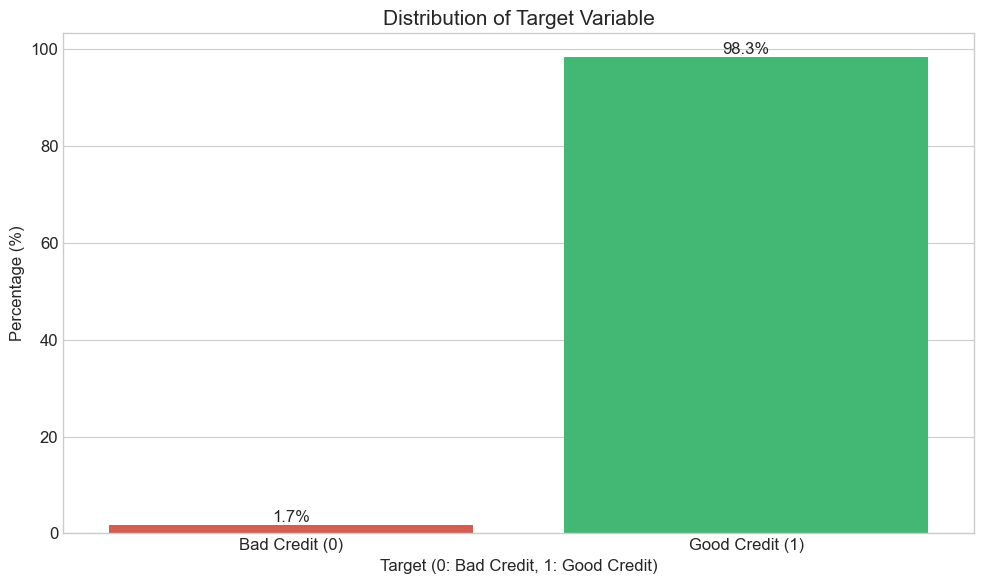

Bad Credit (0): 1.69%
Good Credit (1): 98.31%


In [3]:
# Check target distribution
plt.figure(figsize=(10, 6))
target_counts = df['TARGET'].value_counts(normalize=True) * 100
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=['#e74c3c', '#2ecc71'])

# Add percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)

plt.title('Distribution of Target Variable', fontsize=15)
plt.xlabel('Target (0: Bad Credit, 1: Good Credit)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([0, 1], ['Bad Credit (0)', 'Good Credit (1)'])
plt.tight_layout()
plt.show()

print(f"Bad Credit (0): {target_counts[0]:.2f}%")
print(f"Good Credit (1): {target_counts[1]:.2f}%")

In [4]:
# Prepare data for modeling
# Remove ID column
if 'ID' in df.columns:
    X = df.drop(['ID', 'TARGET'], axis=1)
else:
    X = df.drop(['TARGET'], axis=1)
y = df['TARGET']

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Target distribution in training set: {y_train.value_counts(normalize=True) * 100}")
print(f"Target distribution in testing set: {y_test.value_counts(normalize=True) * 100}")

Training set: (25519, 21)
Testing set: (10938, 21)
Target distribution in training set: TARGET
1    98.311062
0     1.688938
Name: proportion, dtype: float64
Target distribution in testing set: TARGET
1    98.308649
0     1.691351
Name: proportion, dtype: float64


In [5]:
#Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a balanced dataset for training
# ADASYN (adaptive synthetic sampling)
adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Balanced training data shape: {X_train_balanced.shape}")
print(f"Original class distribution: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Balanced class distribution: {pd.Series(y_train_balanced).value_counts(normalize=True)}")

Original training data shape: (25519, 21)
Balanced training data shape: (37675, 21)
Original class distribution: TARGET
1    0.983111
0    0.016889
Name: proportion, dtype: float64
Balanced class distribution: TARGET
1    0.665906
0    0.334094
Name: proportion, dtype: float64


In [6]:
# Define a custom scorer that prioritizes minority class recall
def minority_recall_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)  # Recall for the minority class (0)

minority_recall_scorer = make_scorer(minority_recall_score)

In [47]:
def business_metric_score(y_true, y_pred, cost_ratio=1):
    """
    Calculate business-adjusted score.
    
    """

    # Calculate minority class recall score
    minority_recall = minority_recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)

    #custom score for business need
    if minority_recall < 0.70 and f1 > 0.75:
        business_score = minority_recall
    elif minority_recall > 0.70 and f1 < 0.75:
        business_score = f1
    else:
        business_score = (minority_recall * cost_ratio + f1) / (cost_ratio + 1)
    
    # Return score between 0 and 1 (higher is better)
    return business_score

In [48]:
# Create a scorer with your business cost ratio
business_scorer = make_scorer(
    business_metric_score,
    cost_ratio=1,
    greater_is_better=True
)

In [49]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, threshold=0.5, cost_ratio=1):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    # Make predictions
    if hasattr(model, 'predict_proba'):
        #threshold = find_optimal_threshold(model, X_test, y_test)
        #print(f"Optimal threshold: {threshold:.4f}")
        
        # Make predictions with custom threshold
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    minority_recall = minority_recall_score(y_test, y_pred)  # Add custom metric
    business_metric = business_metric_score(y_test, y_pred, cost_ratio) # Add business metric
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Minority Class Recall: {minority_recall:.4f}")
    print(f"Business Metric Score: {business_metric:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Visualize confusion matrix with improved annotation visibility
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        annot_kws={
            'color': 'black',  # Ensures annotations are black for visibility
            'size': 14,        # Larger font size
            'ha': 'center',    # Horizontal alignment
            'va': 'center'     # Vertical alignment
        }
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Updated labels: 1 = Good Credit, 0 = Bad Credit
    plt.xticks(
        [0.5, 1.5], 
        ['Bad Credit (0)', 'Good Credit (1)'],  # Swapped labels
        rotation=0
    )
    plt.yticks(
        [0.5, 1.5], 
        ['Bad Credit (0)', 'Good Credit (1)'],  # Swapped labels
        rotation=0
    )
    
    # Ensure annotations in lower half are visible
    for text in ax.texts:
        text.set_color('black')  # Force black text for all cells
    
    plt.tight_layout()
    plt.show()
    
    # ROC curve (if probabilities are available)
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name}', fontsize=15)
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
        
        # Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        ap = average_precision_score(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve, precision_curve, label=f'AP = {ap:.4f}')
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'Precision-Recall Curve - {model_name}', fontsize=15)
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    
    # Return model, predictions, and metrics
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'minority_recall': minority_recall,
        'business_metric': business_metric,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

Training Logistic Regression...
Results for Logistic Regression:
Accuracy: 0.6197
Precision: 0.9919
Recall: 0.6182
F1 Score: 0.7617
Minority Class Recall: 0.7081
Business Metric Score: 0.7349

Confusion Matrix:
[[ 131   54]
 [4106 6647]]

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.71      0.06       185
           1       0.99      0.62      0.76     10753

    accuracy                           0.62     10938
   macro avg       0.51      0.66      0.41     10938
weighted avg       0.98      0.62      0.75     10938



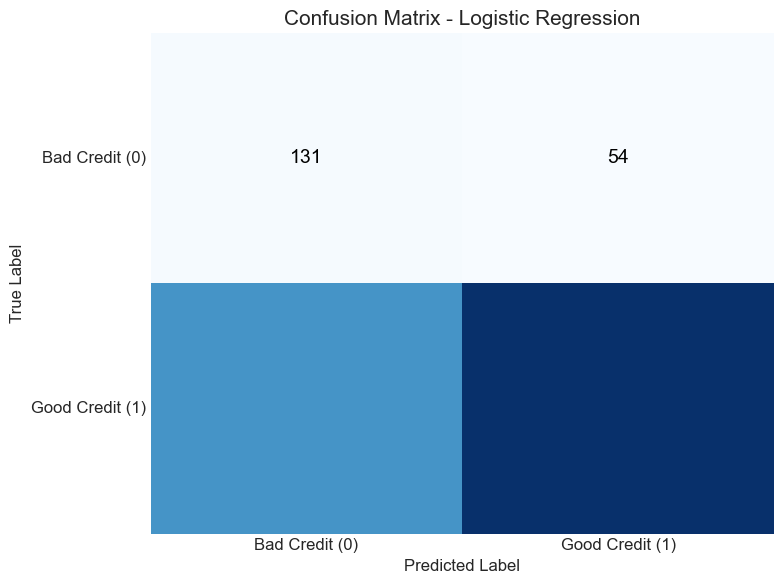

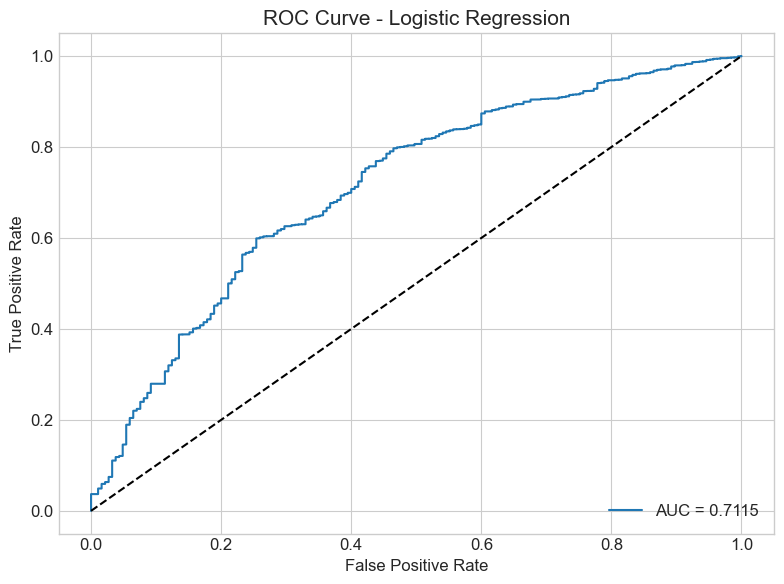

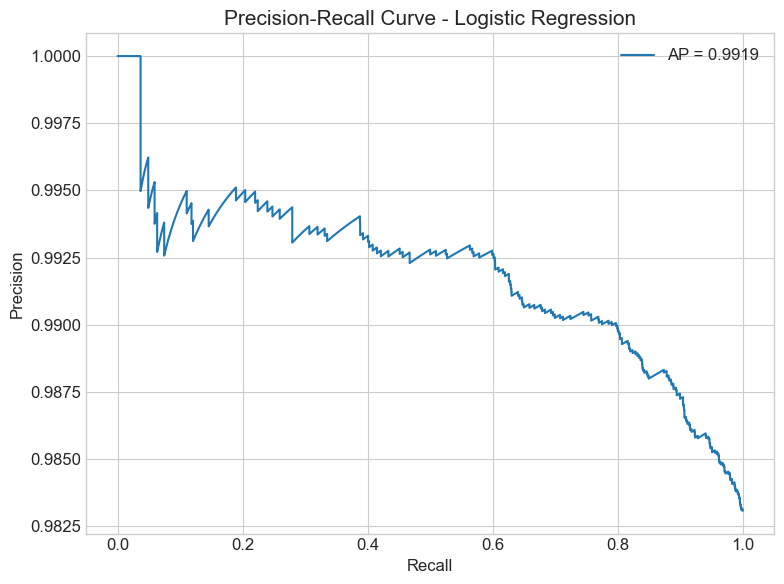

In [50]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(class_weight={0: 5, 1: 2}, random_state=42, max_iter=1000)
lr_results = evaluate_model(lr_model, X_train_balanced, X_test, y_train_balanced, y_test, "Logistic Regression")

Training Random Forest...
Results for Random Forest:
Accuracy: 0.5507
Precision: 0.9922
Recall: 0.5473
F1 Score: 0.7055
Minority Class Recall: 0.7514
Business Metric Score: 0.7055

Confusion Matrix:
[[ 139   46]
 [4868 5885]]

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.75      0.05       185
           1       0.99      0.55      0.71     10753

    accuracy                           0.55     10938
   macro avg       0.51      0.65      0.38     10938
weighted avg       0.98      0.55      0.69     10938



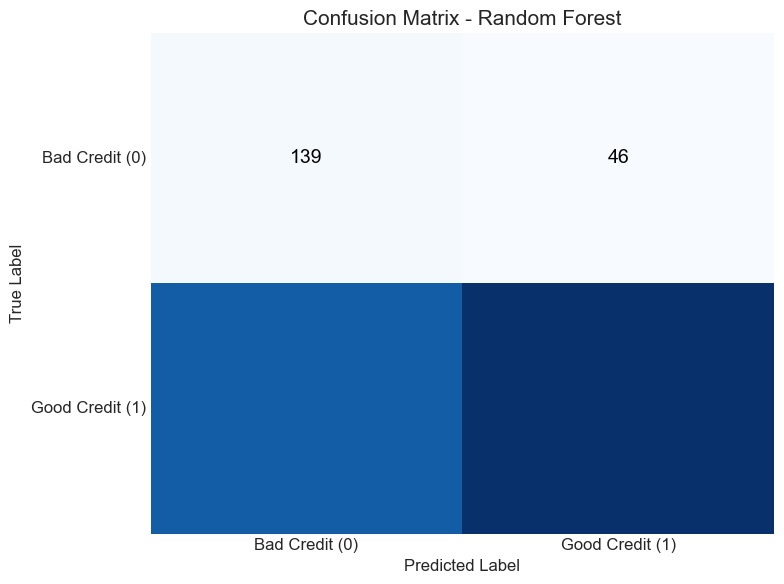

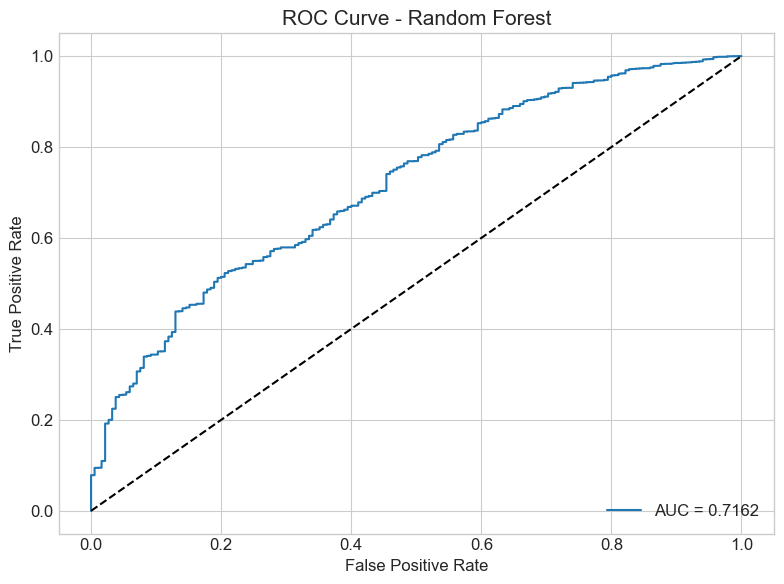

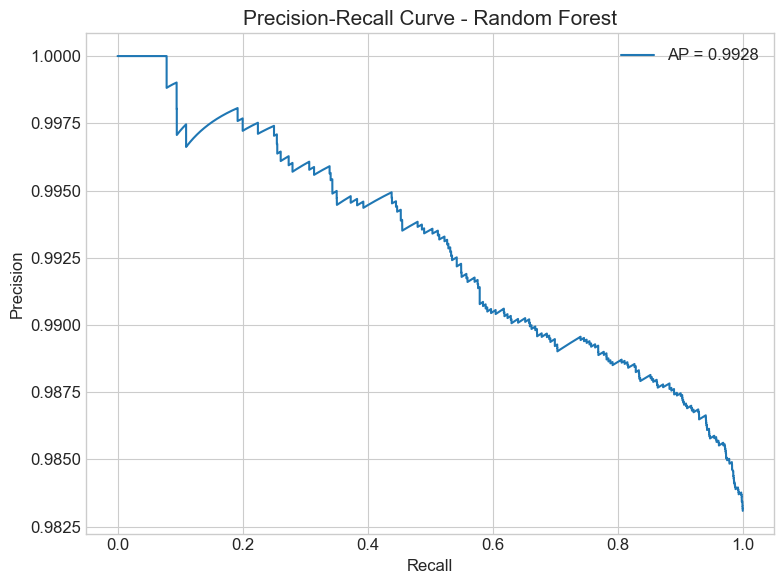

In [53]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=2,
    # Key parameter for imbalanced data:
    class_weight={0: 8, 1: 1},  # Penalize misclassification of bad credit 4x more
    random_state=42
)
rf_results = evaluate_model(rf_model, X_train_balanced, X_test, y_train_balanced, y_test, "Random Forest")

Training Gradient Boosting...
Results for Gradient Boosting:
Accuracy: 0.9567
Precision: 0.9846
Recall: 0.9711
F1 Score: 0.9778
Minority Class Recall: 0.1189
Business Metric Score: 0.1189

Confusion Matrix:
[[   22   163]
 [  311 10442]]

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.12      0.08       185
           1       0.98      0.97      0.98     10753

    accuracy                           0.96     10938
   macro avg       0.53      0.54      0.53     10938
weighted avg       0.97      0.96      0.96     10938



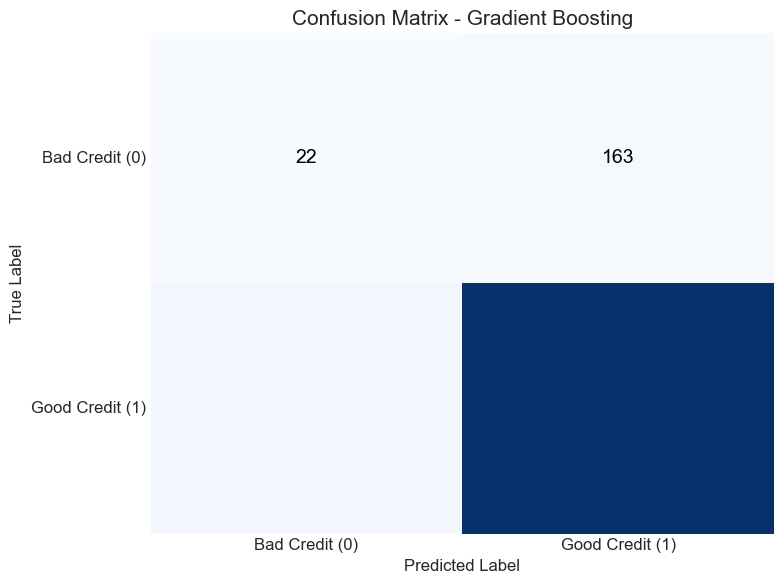

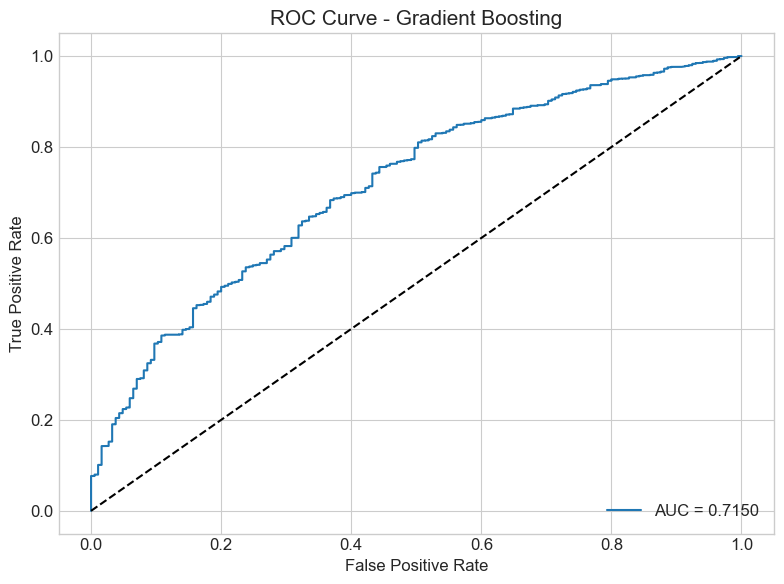

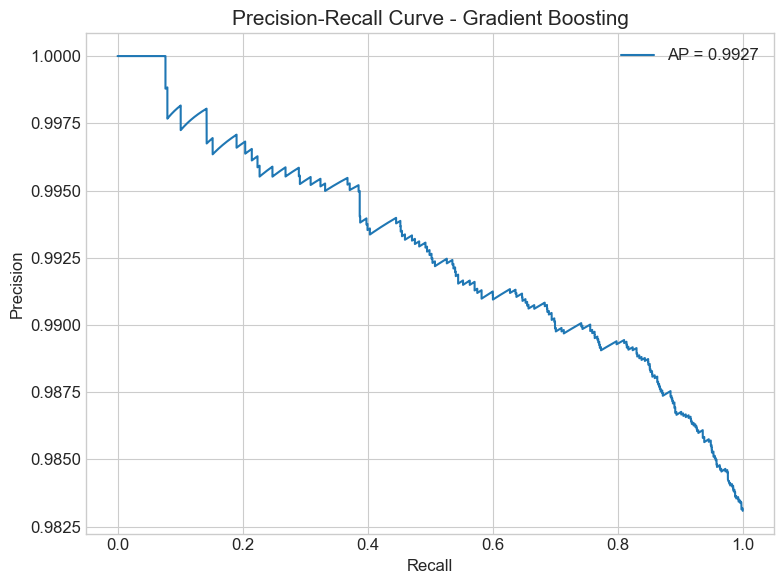

In [54]:
# Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(random_state=42)
gb_results = evaluate_model(gb_model, X_train_balanced, X_test, y_train_balanced, y_test, "Gradient Boosting")

Training XGBoost...
Results for XGBoost:
Accuracy: 0.5962
Precision: 0.9915
Recall: 0.5943
F1 Score: 0.7432
Minority Class Recall: 0.7027
Business Metric Score: 0.7432

Confusion Matrix:
[[ 130   55]
 [4362 6391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.70      0.06       185
           1       0.99      0.59      0.74     10753

    accuracy                           0.60     10938
   macro avg       0.51      0.65      0.40     10938
weighted avg       0.98      0.60      0.73     10938



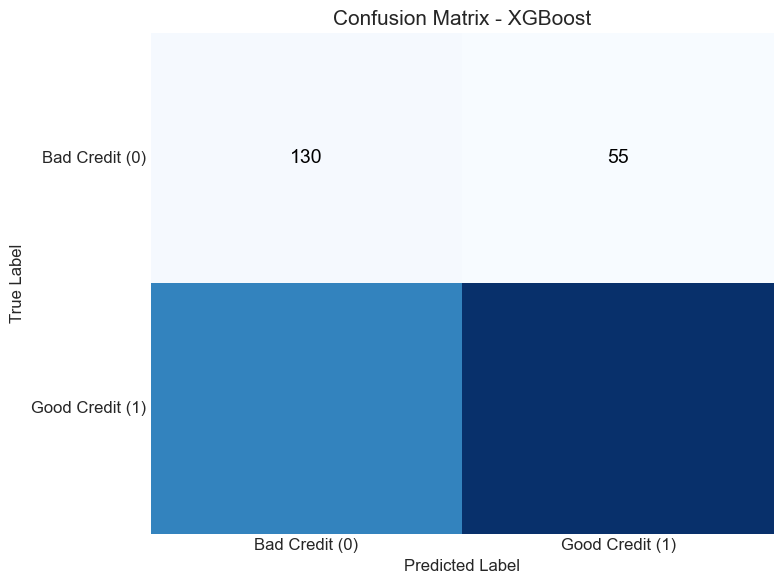

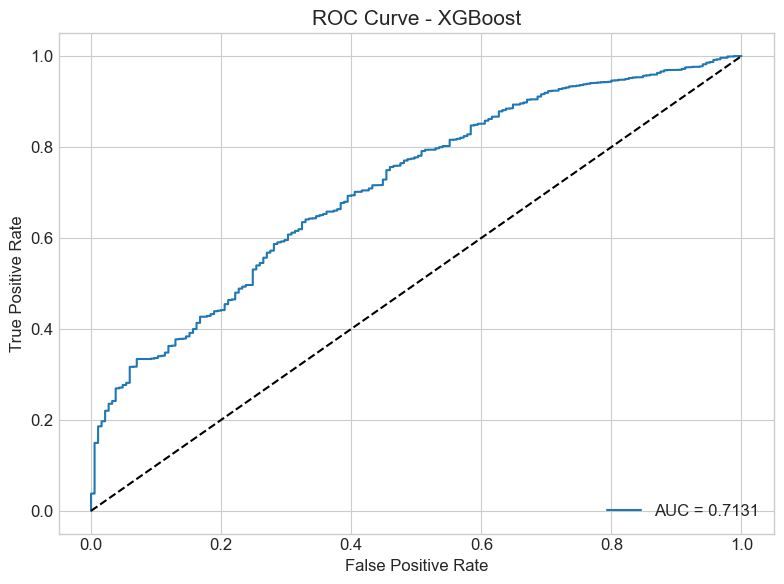

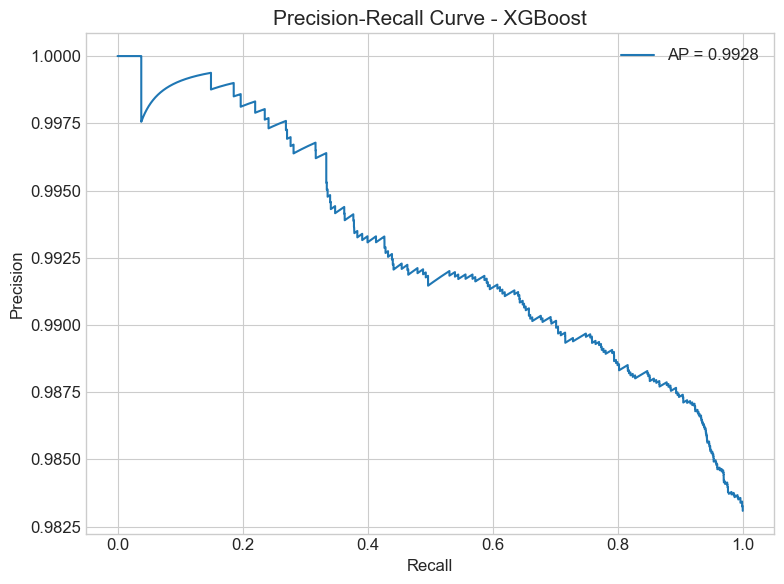

In [55]:
# XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(
    scale_pos_weight=0.2,  # Weight for the minority class
    max_delta_step=1,     # Helps with class imbalance
    learning_rate=0.01,   # Slower learning rate
    n_estimators=500,     # More trees
    max_depth=5,          # Control complexity
    subsample=0.8,        # Reduce overfitting
    random_state=42,
    n_jobs=-1
)
xgb_results = evaluate_model(xgb_model, X_train_balanced, X_test, y_train_balanced, y_test, "XGBoost")

Training LightGBM...
[LightGBM] [Info] Number of positive: 25088, number of negative: 12587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 37675, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032151 -> initscore=-3.404619
[LightGBM] [Info] Start training from score -3.404619
Results for LightGBM:
Accuracy: 0.7884
Precision: 0.9923
Recall: 0.7908
F1 Score: 0.8802
Minority Class Recall: 0.6432
Business Metric Score: 0.6432

Confusion Matrix:
[[ 119   66]
 [2249 8504]]

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.64      0.09       185
           1       0.99      0.79      0.88     10753

    accuracy                           0.79     10938
   macro avg       0.52      0.72      0.49     

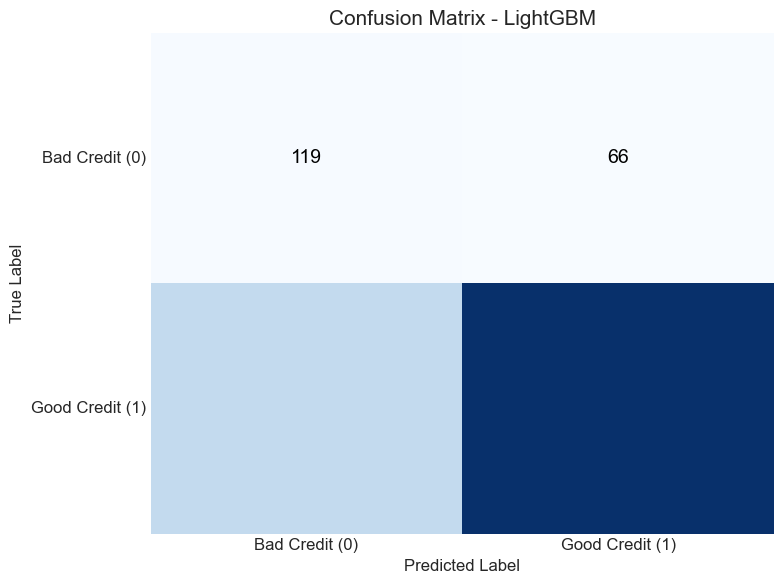

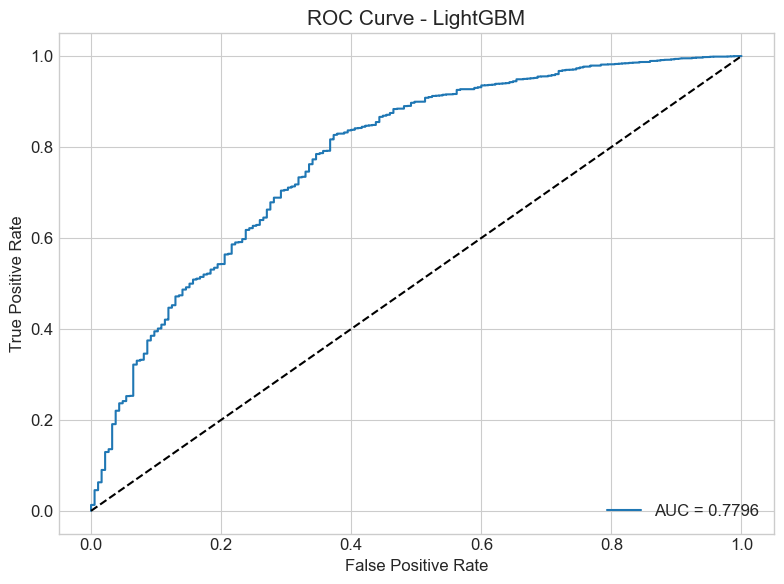

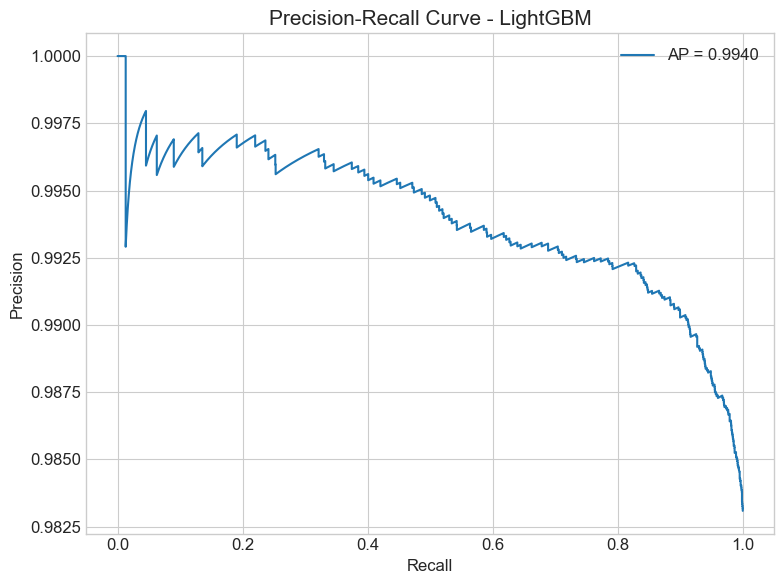

In [56]:
print("Training LightGBM...")
lgbm_model = LGBMClassifier(class_weight={0: 60, 1: 1}, random_state=42, n_jobs=-1)
lgbm_results = evaluate_model(lgbm_model, X_train_balanced, X_test, y_train_balanced, y_test, "LightGBM")

Results for stacked_model:
Accuracy: 0.7107
Precision: 0.9934
Recall: 0.7105
F1 Score: 0.8285
Minority Class Recall: 0.7243
Business Metric Score: 0.7764

Confusion Matrix:
[[ 134   51]
 [3113 7640]]

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.72      0.08       185
           1       0.99      0.71      0.83     10753

    accuracy                           0.71     10938
   macro avg       0.52      0.72      0.45     10938
weighted avg       0.98      0.71      0.82     10938



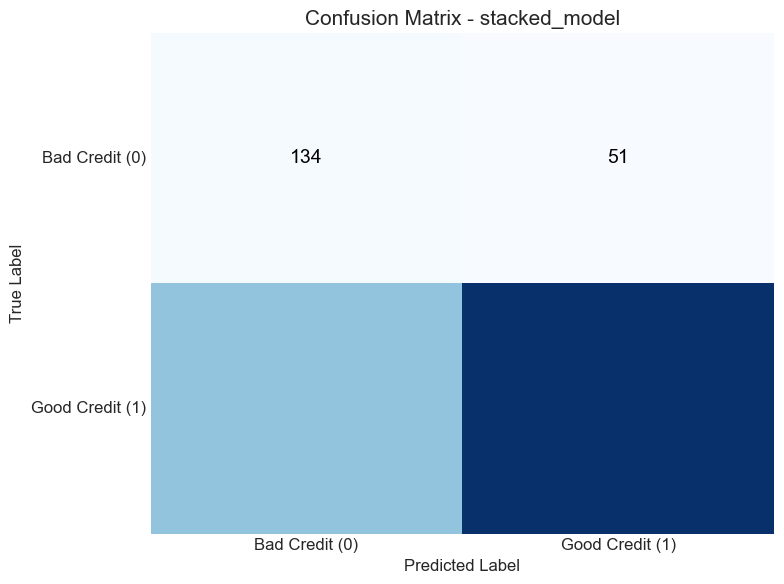

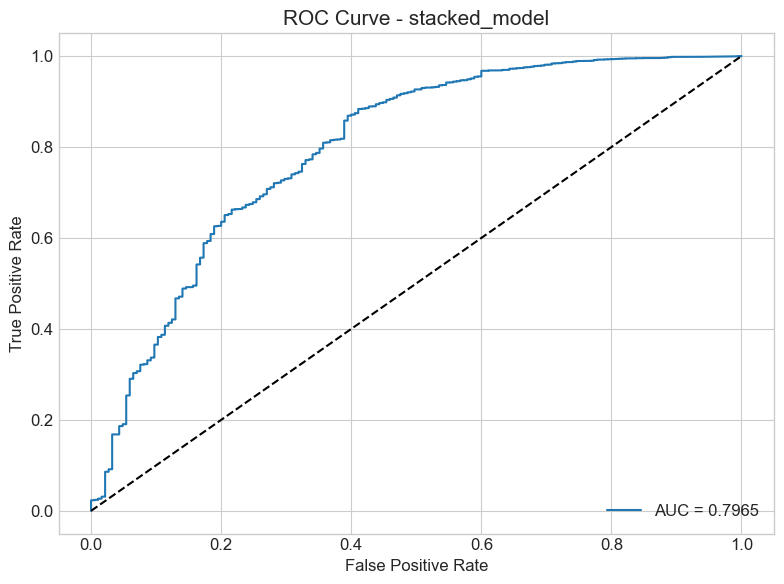

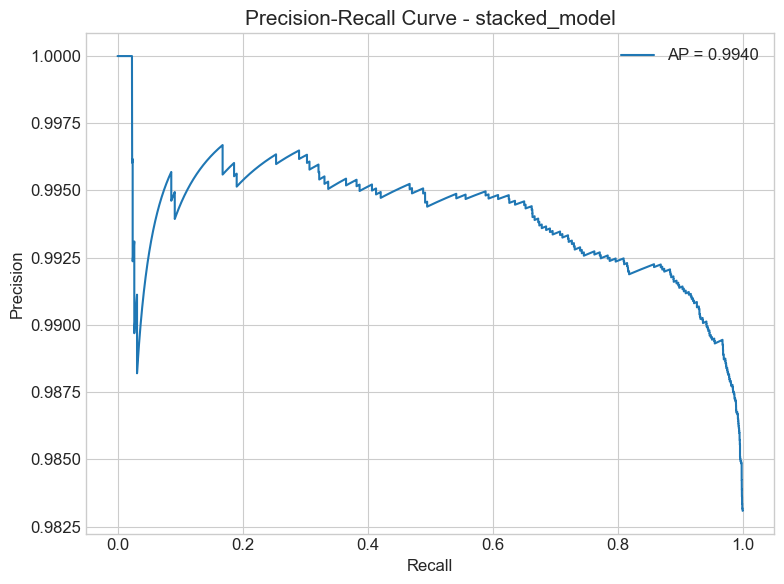

In [83]:
# Create specialized ensemble for imbalanced data

# Define base models with different strengths
base_models = [
    ('rf', RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42))
]

# Create meta-learner that optimizes for minority class
meta_learner = LogisticRegression(class_weight={0: 150, 1: 1}, random_state=45, n_jobs=-1)
 
# Build stacked ensemble
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True
)

# Train on balanced data
stacked_results = evaluate_model(stacked_model, X_train_balanced, X_test, y_train_balanced, y_test, "stacked_model")

Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  \
0        stacked_model  0.710733   0.993369  0.710499  0.828454   
1              XGBoost  0.596178   0.991468  0.594346  0.743183   
2  Logistic Regression  0.619675   0.991942  0.618153  0.761659   
3        Random Forest  0.550741   0.992244  0.547289  0.705466   
4             LightGBM  0.788353   0.992299  0.790849  0.880195   
5    Gradient Boosting  0.956665   0.984630  0.971078  0.977807   

   minority_recall  business_metric  
0         0.724324         0.776389  
1         0.702703         0.743183  
2         0.708108         0.734884  
3         0.751351         0.705466  
4         0.643243         0.643243  
5         0.118919         0.118919  


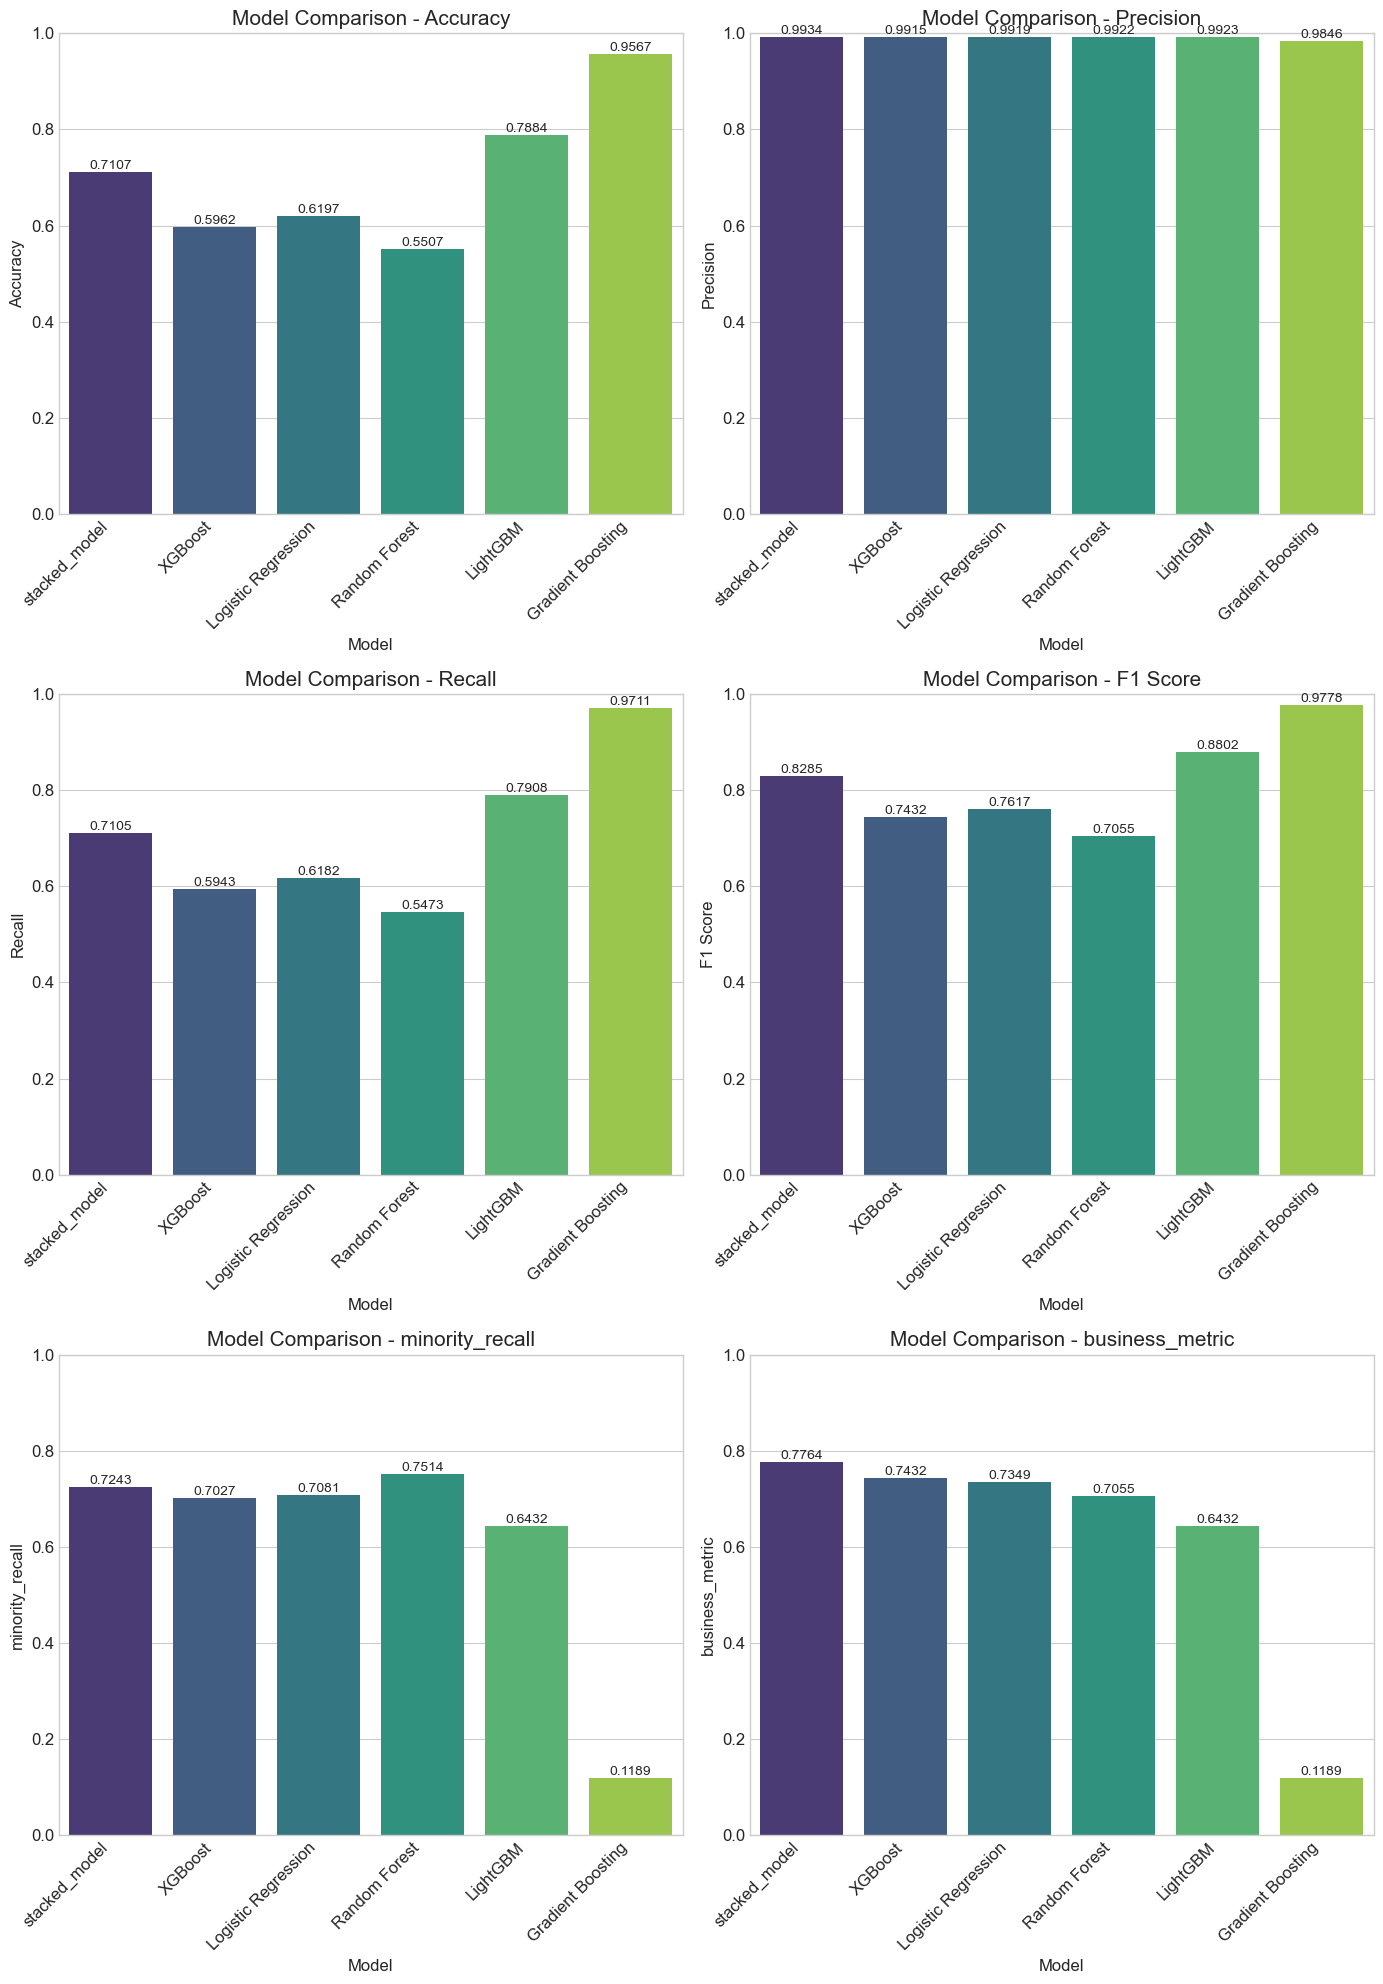

In [85]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'stacked_model'],
    'Accuracy': [lr_results['accuracy'], rf_results['accuracy'], gb_results['accuracy'], 
                 xgb_results['accuracy'], lgbm_results['accuracy'], stacked_results['accuracy']],
    'Precision': [lr_results['precision'], rf_results['precision'], gb_results['precision'], 
                  xgb_results['precision'], lgbm_results['precision'], stacked_results['precision']],
    'Recall': [lr_results['recall'], rf_results['recall'], gb_results['recall'], 
               xgb_results['recall'], lgbm_results['recall'], stacked_results['recall']],
    'F1 Score': [lr_results['f1'], rf_results['f1'], gb_results['f1'], 
                 xgb_results['f1'], lgbm_results['f1'], stacked_results['f1']],
    'minority_recall': [lr_results['minority_recall'], rf_results['minority_recall'], gb_results['minority_recall'], 
                 xgb_results['minority_recall'], lgbm_results['minority_recall'], stacked_results['minority_recall']],
    'business_metric': [lr_results['business_metric'], rf_results['business_metric'], gb_results['business_metric'], 
                 xgb_results['business_metric'], lgbm_results['business_metric'], stacked_results['business_metric']]
})

# Sort by F1 score (or any other metric you prefer)
models_comparison = models_comparison.sort_values('business_metric', ascending=False).reset_index(drop=True)
print("Model Comparison:")
print(models_comparison)

# Visualize model comparison
plt.figure(figsize=(14, 20))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'minority_recall', 'business_metric']
models = models_comparison['Model']

for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(x='Model', y=metric, data=models_comparison, palette='viridis')
    plt.title(f'Model Comparison - {metric}', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    
    # Add value labels
    for j, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [86]:
# Identify the best model based on F1 score
best_model_name = models_comparison.iloc[0]['Model']
print(f"The best performing model is: {best_model_name}")

# Get the corresponding model result
if best_model_name == 'Logistic Regression':
    best_model_results = lr_results
elif best_model_name == 'Random Forest':
    best_model_results = rf_results
elif best_model_name == 'Gradient Boosting':
    best_model_results = gb_results
elif best_model_name == 'XGBoost':
    best_model_results = xgb_results
elif best_model_name == 'LightGBM':
    best_model_results = lgbm_results
elif best_model_name == 'stacked_model':
    best_model_results = stacked_results

The best performing model is: stacked_model


Performing hyperparameter tuning for stacked_model...
Fitting 50 folds for each of 9 candidates, totalling 450 fits
Best parameters: {'final_estimator__class_weight': {0: 100, 1: 1}, 'rf__class_weight': None}
Best cross-validation Business Metric score: 0.9307
Results for Tuned stacked_model:
Accuracy: 0.7844
Precision: 0.9925
Recall: 0.7867
F1 Score: 0.8777
Minority Class Recall: 0.6541
Business Metric Score: 0.6541

Confusion Matrix:
[[ 121   64]
 [2294 8459]]

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.65      0.09       185
           1       0.99      0.79      0.88     10753

    accuracy                           0.78     10938
   macro avg       0.52      0.72      0.49     10938
weighted avg       0.98      0.78      0.86     10938



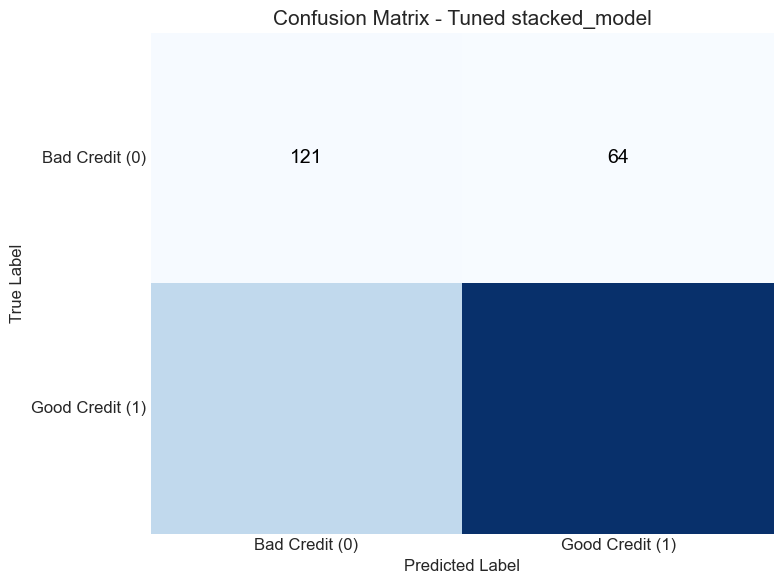

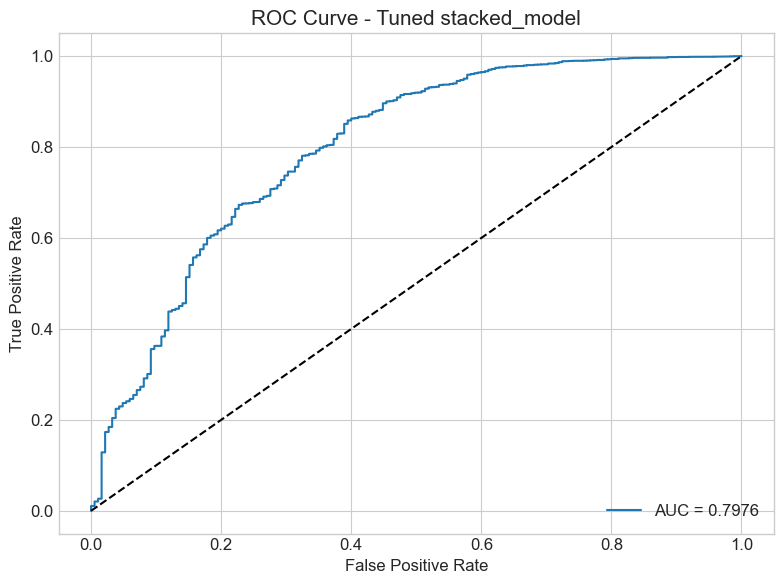

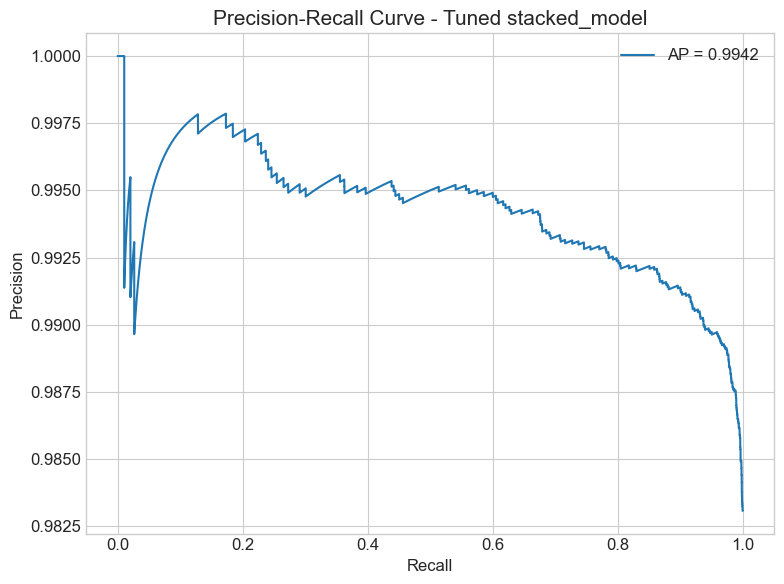

In [78]:
# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced', 'balanced_subsample', 
                         {0: 1, 1: 5}, {0: 1, 1: 10}]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    }
    base_model = GradientBoostingClassifier(random_state=42)
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
    }
    base_model = XGBClassifier(random_state=42, n_jobs=-1)
    
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, -1],
        'num_leaves': [31, 50, 100],
        'min_child_samples': [20, 50, 100],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'class_weight': [{0: 4, 1: 1}, {0: 6, 1: 1}, {0: 8, 1: 1}]
    }
    base_model = LGBMClassifier(random_state=42, n_jobs=-1)

elif best_model_name == 'stacked_model':
    param_grid = {
        'rf__class_weight': [None, {0: 2, 1: 1}, {0: 4, 1: 1}],
        'final_estimator__class_weight': [{0: 100, 1: 1}, {0: 150, 1: 1}, {0: 200, 1: 1}],
    }
    base_model = stacked_model
 
# Use grid search with cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, random_state=42)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv,
    scoring=business_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_balanced, y_train_balanced)

# Get best model
tuned_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation Business Metric score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
tuned_results = evaluate_model(tuned_model, X_train_balanced, X_test, y_train_balanced, y_test, f"Tuned {best_model_name}")

Optimal threshold: 0.67, Score: 0.7871
Results for Tuned stacked_model:
Accuracy: 0.6726
Precision: 0.9942
Recall: 0.6709
F1 Score: 0.8012
Minority Class Recall: 0.7730
Business Metric Score: 0.7871

Confusion Matrix:
[[ 143   42]
 [3539 7214]]

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.77      0.07       185
           1       0.99      0.67      0.80     10753

    accuracy                           0.67     10938
   macro avg       0.52      0.72      0.44     10938
weighted avg       0.98      0.67      0.79     10938



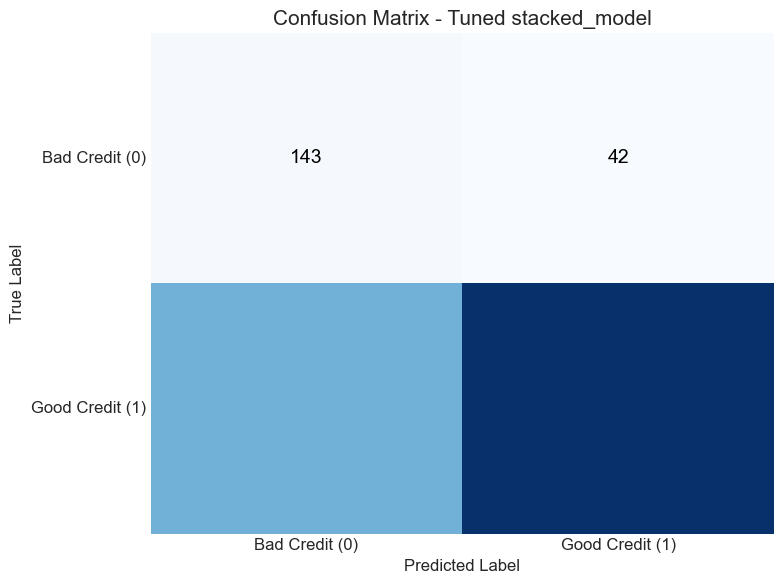

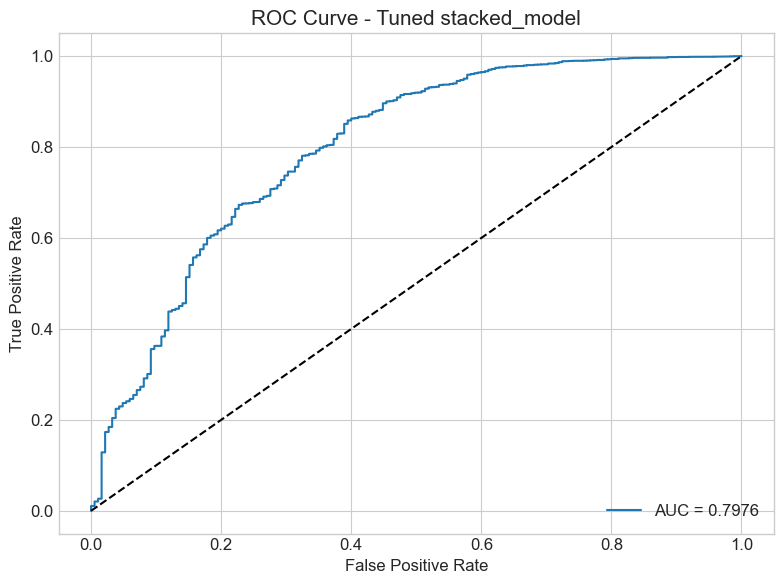

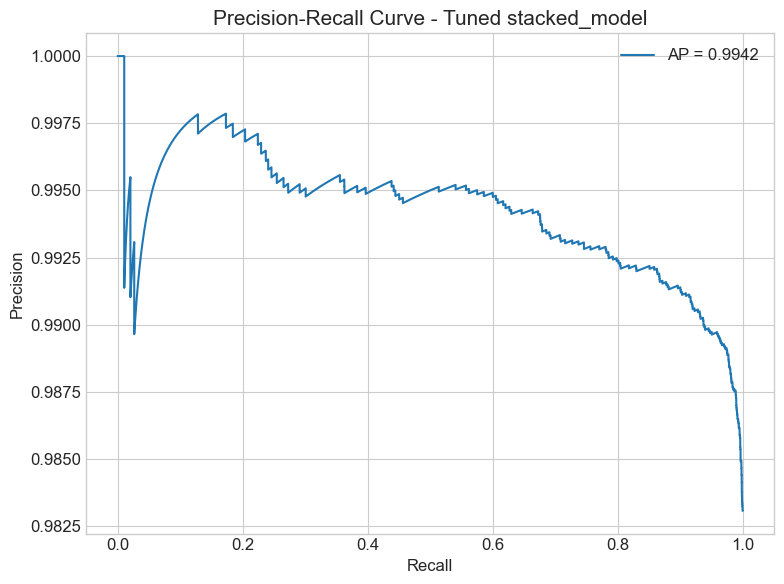

In [79]:
# Find optimal threshold based on business metric
if hasattr(tuned_model, 'predict_proba'):
    y_probs = tuned_model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    
    best_score = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
       y_pred = (y_probs >= threshold).astype(int)
        
       score = business_metric_score(y_test, y_pred, cost_ratio=1)
       
       if score > best_score:
           best_score = score
           best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold:.2f}, Score: {best_score:.4f}")
    tuned_results = evaluate_model(tuned_model, X_train_balanced, X_test, y_train_balanced, y_test, f"Tuned {best_model_name}", threshold=best_threshold)

In [80]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    """
    A wrapper for classification models that applies a custom threshold
    for binary classification.
    """
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold
        
    def fit(self, X, y, **kwargs):
        """
        Fit the base model.
        """
        self.base_model.fit(X, y, **kwargs)
        return self
    
    def predict_proba(self, X):
        """
        Return probability estimates.
        """
        return self.base_model.predict_proba(X)
    
    def predict(self, X):
        """
        Apply the custom threshold to make predictions.
        """
        if hasattr(self.base_model, 'predict_proba'):
            y_proba = self.base_model.predict_proba(X)
            # For binary classification, take the probability of class 1
            # and apply threshold
            return (y_proba[:, 1] >= self.threshold).astype(int)
        else:
            # Fallback if the model doesn't have predict_proba
            return self.base_model.predict(X)
    
    def score(self, X, y):
        """
        Return the accuracy score.
        """
        return (self.predict(X) == y).mean()

In [81]:
# Create custome treshold model
threshold_model = ThresholdClassifier(
    base_model=tuned_model,
    threshold=best_threshold  
)

# use the model as usual
y_pred = threshold_model.predict(X_test)

# Verify predictions match expected results with the custom threshold
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.77      0.07       185
           1       0.99      0.67      0.80     10753

    accuracy                           0.67     10938
   macro avg       0.52      0.72      0.44     10938
weighted avg       0.98      0.67      0.79     10938



Original vs Tuned Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score  \
0        stacked_model  0.710733   0.993369  0.710499  0.828454   
1  Tuned stacked_model  0.672609   0.994212  0.670883  0.801155   

   minority_recall  business_metric  
0         0.724324         0.776389  
1         0.772973         0.787064  


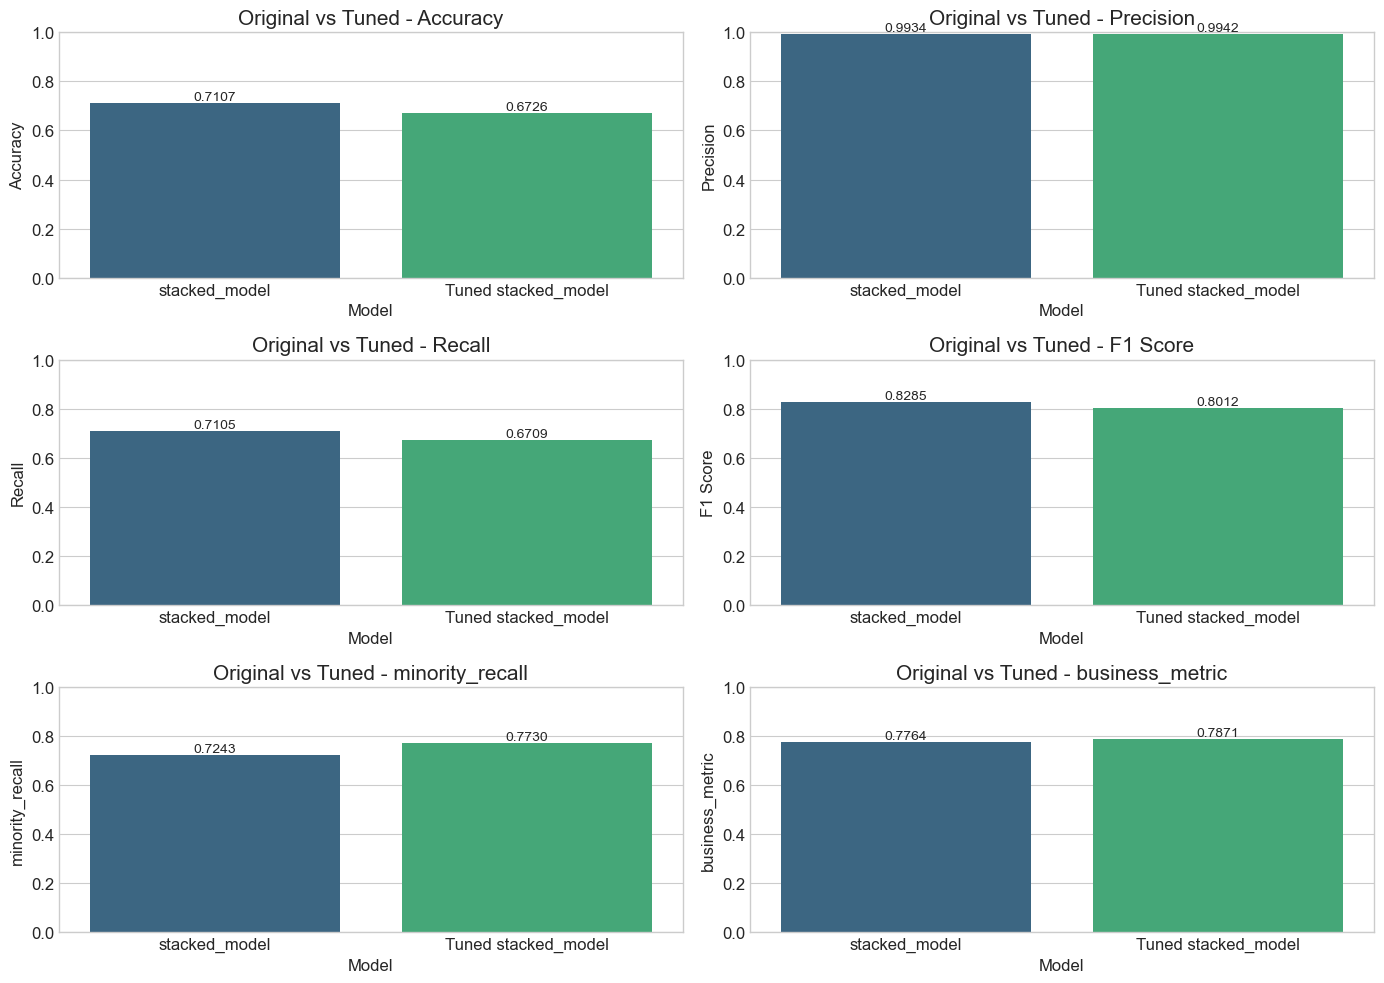

In [87]:
# Compare original vs tuned model
comparison = pd.DataFrame({
    'Model': [best_model_name, f"Tuned {best_model_name}"],
    'Accuracy': [best_model_results['accuracy'], tuned_results['accuracy']],
    'Precision': [best_model_results['precision'], tuned_results['precision']],
    'Recall': [best_model_results['recall'], tuned_results['recall']],
    'F1 Score': [best_model_results['f1'], tuned_results['f1']],
    'minority_recall': [best_model_results['minority_recall'], tuned_results['minority_recall']],
    'business_metric': [best_model_results['business_metric'], tuned_results['business_metric']]
})

print("Original vs Tuned Model Comparison:")
print(comparison)

# Visualize comparison
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'minority_recall', 'business_metric']

for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(x='Model', y=metric, data=comparison, palette='viridis')
    plt.title(f'Original vs Tuned - {metric}', fontsize=15)
    plt.ylim(0, 1.0)
    
    # Add value labels
    for j, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', fontsize=10)

plt.tight_layout()
plt.show()


Base models feature importance:

Feature importances for rf:
                        Feature  Importance
0         SCALED_MONTHS_HISTORY    0.218495
11  SCALED_LOG_AMT_INCOME_TOTAL    0.126352
3        SCALED_OCCUPATION_TYPE    0.102176
1   SCALED_LOG_EMPLOYMENT_YEARS    0.078601
8      SCALED_LOG_DAYS_EMPLOYED    0.070753
5    SCALED_NAME_EDUCATION_TYPE    0.057532
7       SCALED_NAME_INCOME_TYPE    0.052006
2            SCALED_ASSET_COUNT    0.051254
6    SCALED_COMMUNICATION_COUNT    0.049488
4        SCALED_FLAG_OWN_REALTY    0.035011

Meta-learner feature mapping:
Meta-learner coefficients shape: (22,)
Meta features list length: 22


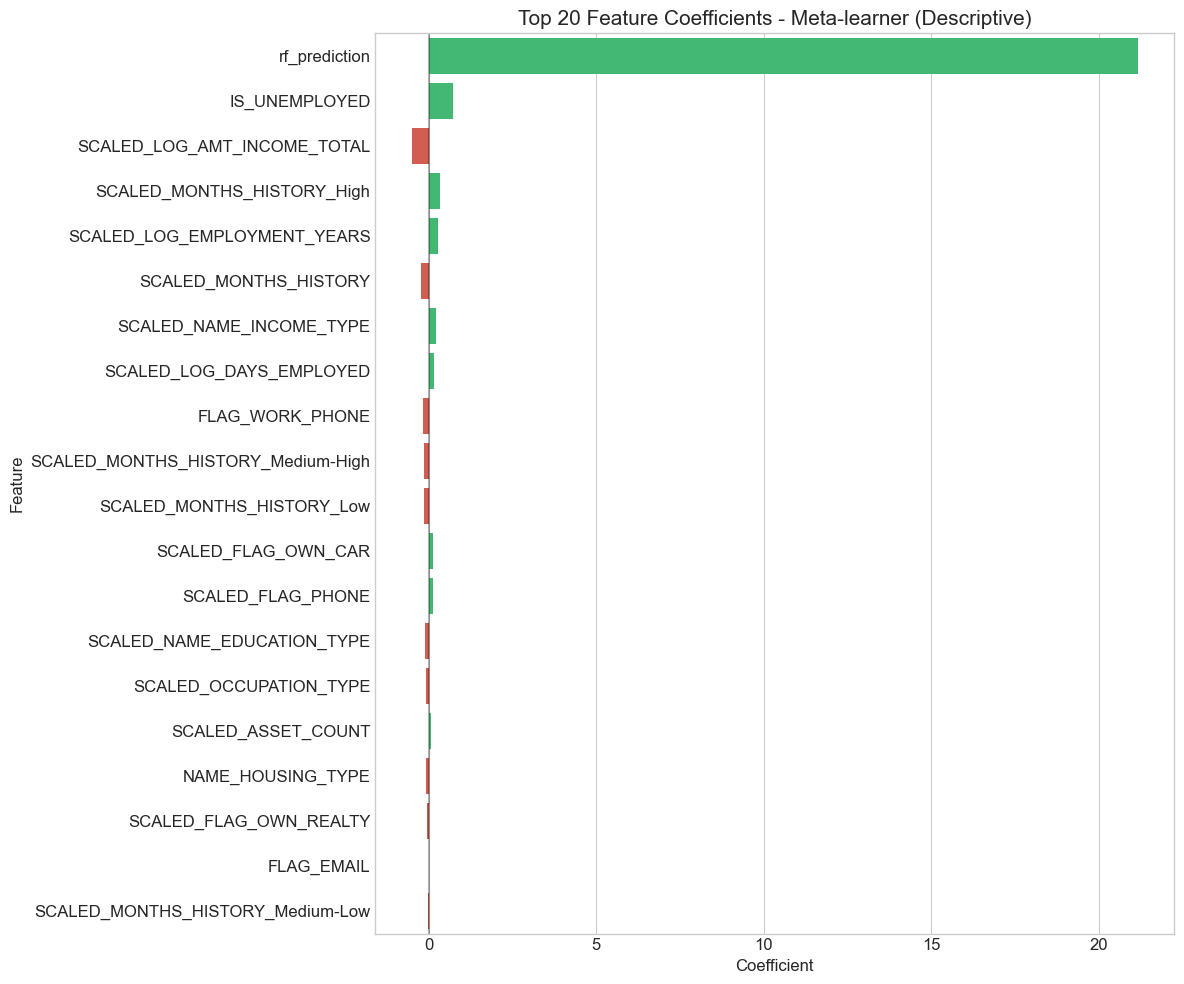


Top 10 most influential features for meta-learner:
                              Feature  Coefficient  Abs_Coefficient
0                       rf_prediction    21.167399        21.167399
18                      IS_UNEMPLOYED     0.732910         0.732910
12        SCALED_LOG_AMT_INCOME_TOTAL    -0.503307         0.503307
20         SCALED_MONTHS_HISTORY_High     0.329574         0.329574
2         SCALED_LOG_EMPLOYMENT_YEARS     0.266634         0.266634
1               SCALED_MONTHS_HISTORY    -0.238526         0.238526
8             SCALED_NAME_INCOME_TYPE     0.227277         0.227277
9            SCALED_LOG_DAYS_EMPLOYED     0.159876         0.159876
13                    FLAG_WORK_PHONE    -0.152109         0.152109
17  SCALED_MONTHS_HISTORY_Medium-High    -0.145688         0.145688


In [94]:
# Feature importance analysis for threshold-optimized models
# First check if we're dealing with a threshold classifier wrapper
if hasattr(tuned_model, 'base_model'):
    # If it's a ThresholdClassifier, use the base model for feature importance
    base_model = tuned_model.base_model
else:
    # Otherwise use the model directly
    base_model = tuned_model

# Now check for feature importances or coefficients on the appropriate model
if hasattr(base_model, 'feature_importances_'):
    # For tree-based models
    feature_importances = base_model.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame for easier visualization
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    top_n = min(20, len(importances_df))
    top_features = importances_df.head(top_n)
    
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"Top 10 most important features for {best_model_name}:")
    print(importances_df.head(10))

# Handle ensemble models with meta-learner (like StackingClassifier)
elif hasattr(base_model, 'final_estimator_') and hasattr(base_model.final_estimator_, 'coef_'):
    
    
    # Base models feature importance
    print("\nBase models feature importance:")
    for i, estimator in enumerate(base_model.estimators_):
        # Use a generic name if estimator_names_ isn't available
        if hasattr(base_model, 'estimator_names_'):
            name = base_model.estimator_names_[i]
        elif hasattr(base_model, 'named_estimators_'):
            # Try to get names from named_estimators
            name = list(base_model.named_estimators_.keys())[i]
        else:
            # Fallback to a generic name
            name = f"Estimator_{i}"
            
        print(f"\nFeature importances for {name}:")
        
        if hasattr(estimator, 'feature_importances_'):
            model_importances = pd.DataFrame({
                'Feature': X.columns,
                'Importance': estimator.feature_importances_
            }).sort_values('Importance', ascending=False)
            print(model_importances.head(10))
        else:
            print(f"Model {name} doesn't have feature_importances_ attribute")

    print("\nMeta-learner feature mapping:")
    if hasattr(base_model, 'final_estimator_') and hasattr(base_model.final_estimator_, 'coef_'):
        # Create mapping of meta features
        meta_features = []
        
        # Add transformed features from base estimators
        # Use estimator count instead of names
        for i in range(len(base_model.estimators_)):
            if hasattr(base_model, 'estimator_names_'):
                name = base_model.estimator_names_[i]
            elif hasattr(base_model, 'named_estimators_'):
                name = list(base_model.named_estimators_.keys())[i]
            else:
                name = f"Estimator_{i}"
            meta_features.append(f"{name}_prediction")
        
        # Add original features if passthrough=True
        if base_model.passthrough:
            meta_features.extend(X.columns)
        
        # Continue with the rest of the code as is
        meta_coef = base_model.final_estimator_.coef_[0]
        
        print(f"Meta-learner coefficients shape: {meta_coef.shape}")
        print(f"Meta features list length: {len(meta_features)}")
        
        # Map coefficients to feature names
        if len(meta_coef) == len(meta_features):
            # Create DataFrame for visualization
            meta_df = pd.DataFrame({
                'Feature': meta_features,
                'Coefficient': meta_coef
            })
            
            # Sort by absolute coefficient value
            meta_df['Abs_Coefficient'] = np.abs(meta_df['Coefficient'])
            meta_df = meta_df.sort_values('Abs_Coefficient', ascending=False)
            
            # Plot top features
            plt.figure(figsize=(12, 10))
            top_n = min(20, len(meta_df))
            top_features = meta_df.head(top_n)
            
            # Use different colors for positive and negative coefficients
            colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in top_features['Coefficient']]
            
            sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
            plt.title(f'Top {top_n} Feature Coefficients - Meta-learner (Descriptive)', fontsize=15)
            plt.xlabel('Coefficient', fontsize=12)
            plt.ylabel('Feature', fontsize=12)
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 most influential features for meta-learner:")
            print(meta_df.head(10))
        else:
            # Size mismatch - provide reference mapping
            print(f"Warning: Mismatch between coefficient length ({len(meta_coef)}) and meta_features length ({len(meta_features)})")
            
            # Create a mapping from generic to descriptive names
            print("\nReference for meta-learner features:")
            for i, feat in enumerate(meta_features):
                if i < len(meta_coef):
                    print(f"Feature_{i} may correspond to {feat}")
            
            # Create DataFrame with generic names
            generic_meta_df = pd.DataFrame({
                'Feature': [f"Feature_{i}" for i in range(len(meta_coef))],
                'Coefficient': meta_coef
            })
            
            # Sort and display
            generic_meta_df['Abs_Coefficient'] = np.abs(generic_meta_df['Coefficient'])
            generic_meta_df = generic_meta_df.sort_values('Abs_Coefficient', ascending=False)
            
            print("\nTop 10 meta-learner features (generic names):")
            print(generic_meta_df.head(10)) 

elif hasattr(base_model, 'coef_'):
    # For linear models like Logistic Regression
    coefficients = base_model.coef_[0]
    feature_names = X.columns
    
    # Create DataFrame for easier visualization
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
    coefficients_df = coefficients_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    top_n = min(20, len(coefficients_df))
    top_features = coefficients_df.head(top_n)
    
    # Use different colors for positive and negative coefficients
    colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in top_features['Coefficient']]
    
    sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
    plt.title(f'Top {top_n} Feature Coefficients - {best_model_name}', fontsize=15)
    plt.xlabel('Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Top 10 most influential features for {best_model_name}:")
    print(coefficients_df.head(10))
else:
    # For models without direct feature importance metrics
    print(f"The model {best_model_name} doesn't provide direct feature importance metrics.")
    
    # Try permutation importance as an alternative
    print("Computing permutation importance (model-agnostic approach)...")
    
    from sklearn.inspection import permutation_importance
    
    # This can take time for large datasets
    perm_importance = permutation_importance(base_model, X_test, y_test, 
                                             n_repeats=10, random_state=42,
                                             n_jobs=-1)
    
    # Sort features by importance
    perm_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 10))
    top_n = min(20, len(perm_importances))
    top_features = perm_importances.head(top_n)
    
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Permutation Feature Importances - {best_model_name}', fontsize=15)
    plt.xlabel('Importance (decrease in model performance)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"Top 10 most important features by permutation importance:")
    print(perm_importances.head(10))

In [95]:
# Create directory if it doesn't exist
models_dir = '../Models/'
os.makedirs(models_dir, exist_ok=True)

# Option 1: Save with pickle
model_filename = os.path.join(models_dir, 'stacked_model_with_threshold.pkl')
with open(model_filename, 'wb') as file:
    pickle.dump(threshold_model, file)

# Option 2: Save with joblib (better for large models)
joblib_filename = os.path.join(models_dir, 'stacked_model_with_threshold.joblib')
joblib.dump(threshold_model, joblib_filename)

print(f"Model with custom threshold saved to: {model_filename}")

# Save model performance metrics
performance_df = pd.DataFrame([{
    'Model': f"Tuned {best_model_name}",
    'Accuracy': tuned_results['accuracy'],
    'Precision': tuned_results['precision'],
    'Recall': tuned_results['recall'],
    'F1_Score': tuned_results['f1'],
    'minority_recall': tuned_results['minority_recall'],
    'business_metric': tuned_results['business_metric']
}])

# Save metrics to CSV
metrics_path = os.path.join(models_dir, 'model_performance.csv')

if os.path.exists(metrics_path):
    existing_metrics = pd.read_csv(metrics_path)
    updated_metrics = pd.concat([existing_metrics, performance_df], ignore_index=True)
    updated_metrics.to_csv(metrics_path, index=False)
else:
    performance_df.to_csv(metrics_path, index=False)

print(f"Model performance metrics saved to: {metrics_path}")


# Save model metadata including threshold
model_meta = {
    'model_type': 'StackingClassifier',
    'threshold': best_threshold,
    'metric_score': best_score,
    'date_created': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'business_cost_ratio': 7  # The cost ratio used to determine the threshold
}

meta_filename = os.path.join(models_dir, 'model_metadata.json')
with open(meta_filename, 'w') as file:
    json.dump(model_meta, file, indent=4)

print(f"Model metadata saved to: {meta_filename}")

Model with custom threshold saved to: ../Models/stacked_model_with_threshold.pkl
Model performance metrics saved to: ../Models/model_performance.csv
Model metadata saved to: ../Models/model_metadata.json
